In [10]:
% matplotlib inline
import random
import torch
from d2l import torch as d2l

In [11]:
def synthetic_data(w, b, num_exaples):
    # 生成y = Xw + b + 噪声
    X = torch.normal(0, 1, (num_exaples, len(w)))
    print("X.shape:", X.shape)
    y = torch.matmul(X, w) + b
    print("y.shape:", y.shape)
    y += torch.normal(0, 0.01, y.shape)
    print("y.shape:", y.shape)
    return X, y.reshape((-1, 1))

In [12]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
print("features.shape:", features.shape)
print("labels.shape:", labels.shape)

X.shape: torch.Size([1000, 2])
y.shape: torch.Size([1000])
y.shape: torch.Size([1000])
features.shape: torch.Size([1000, 2])
labels.shape: torch.Size([1000, 1])


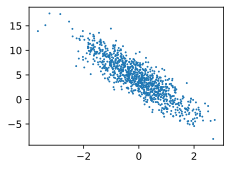

In [13]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1)  # 只有detach后才能转到numpy里面去

In [14]:
# data_iter函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为batch_size的小批量
def data_iter(batch_size, features, labels):
    num_examples = len(features)  #样本个数
    indices = list(range(num_examples))  # 样本索引
    # 这些样本是随机读取的，没有特定的顺寻
    random.shuffle(indices)  # 把样本索引随机打乱
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i + batch_size, num_examples)])  # 当i+batch_size超出时，取num_examples
        yield features[batch_indices], labels[batch_indices]  # 获得随机顺序的特征及标签

In [15]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 1.6731, -0.1984],
        [-2.0318, -1.2281],
        [ 0.7454, -0.2092],
        [ 1.2070, -0.6478],
        [-0.6921, -0.4879],
        [ 0.8276, -0.6598],
        [-0.6179,  0.5926],
        [-0.1264,  0.0741],
        [ 1.3012,  0.4850],
        [ 1.3427, -1.3671]]) 
 tensor([[ 8.2132],
        [ 4.3080],
        [ 6.4031],
        [ 8.8257],
        [ 4.4733],
        [ 8.0965],
        [ 0.9434],
        [ 3.6777],
        [ 5.1468],
        [11.5196]])


In [16]:
# 定义初始化模型参数
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [17]:
# 定义模型
def linreg(X, w, b):
    # 线性回归模型
    return torch.matmul(X, w) + b

In [18]:
# 定义损失函数
def squared_loss(y_hat, y):
    # 均方损失
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [19]:
# 定义优化算法
def sgd(params, lr, batch_size):
    # 小批量随机梯度下降
    with torch.no_grad():  # 不要产生梯度计算，减少内存消耗
        for param in params:
            param -= lr * param.grad / batch_size  # 每个参数进行更新，损失函数没有求均值，所以这里除以 batch_size 求了均值。由于乘法的线性关系，这里除以放在loss的除以是等价的。
            param.grad.zero_()  # 每个参数的梯度清零

In [20]:
# 训练过程
lr = 0.03
num_epochs = 3
net = linreg  # 这里用线性模型，这样写是很方便net赋予其他模型，只需要改一处，不需要下面所有网络模型名称都改
loss = squared_loss

In [23]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # x和y的小批量损失
        # 因为l是形状是(batch_size,1)，而不是一个标量。l中所有元素被加到一起
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch{epoch + 1},loss{float(train_l.mean()):f}')

epoch1,loss0.030285
epoch2,loss0.000100
epoch3,loss0.000048


In [24]:
# 比较真实参数和通过训练学到的参数来评估训练的成功程度
print(f'w的估计误差：{true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差：{true_b - b}')

w的估计误差：tensor([ 0.0006, -0.0009], grad_fn=<SubBackward0>)
b的估计误差：tensor([-6.3896e-05], grad_fn=<RsubBackward1>)


In [25]:
# 使用框架

In [26]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l
from torch import nn

In [27]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)  # 库函数生成人工数据集

In [28]:
# 调用框架现有的API来读取数据
def load_array(data_arrays, batch_size, is_train=True):
    """构造一个Pytorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)  # dataset相当于Pytorch的Dataset。一个星号*，表示对list解开入参。
    return data.DataLoader(dataset, batch_size, shuffle=is_train)  # 返回的是从dataset中随机挑选出batch_size个样本出来

In [29]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)  # 返回数据的迭代器
print(next(iter(data_iter)))  # iter(data_iter) 是一个迭代器对象，next是取迭代器里面的元素

[tensor([[-0.1992, -1.3283],
        [-0.8139,  0.2597],
        [ 0.1783,  0.9476],
        [ 0.5590, -0.6069],
        [ 0.9537, -2.2504],
        [-1.6947,  0.1083],
        [-1.5763,  1.1785],
        [ 0.5148,  0.3723],
        [-0.4325,  0.9209],
        [ 0.3689,  0.5324]]), tensor([[ 8.3309],
        [ 1.6979],
        [ 1.3342],
        [ 7.3830],
        [13.7517],
        [ 0.4380],
        [-2.9628],
        [ 3.9546],
        [ 0.2019],
        [ 3.1001]])]


In [30]:
# 使用框架的预定义好的层
# nn是神经网络的缩写
net = nn.Sequential(nn.Linear(2, 1))

In [31]:
# 初始化模型参数
net[0].weight.data.normal_(0, 0.01)  # 使用正态分布替换掉weight变量里面的数据值
net[0].bias.data.fill_(0)  # 偏差bias变量里面的值设置为0
print(net[0])

Linear(in_features=2, out_features=1, bias=True)


In [32]:
# 计算均方误差使用的是MSELoss类，也称为平方L2范数
loss = nn.MSELoss()

In [33]:
trainer = torch.optim.SGD(net.parameters(), lr=0.3)

In [34]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:  # 从DataLoader里面一次一次把所有数据拿出来
        l = loss(net(X), y)  # net(X) 为计算出来的线性回归的预测值
        trainer.zero_grad()  # 梯度清零
        l.backward()
        trainer.step()  # SGD优化器模型
    l = loss(net(features),labels)
    print(f'epoch{epoch+1},loss{l:f}')

epoch1,loss0.000096
epoch2,loss0.000112
epoch3,loss0.000126
